## Feature selection 

### import libraries


In [879]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif, f_classif, RFE, SequentialFeatureSelector
from sklearn_genetic import GAFeatureSelectionCV
import random
from sklearn.preprocessing import MinMaxScaler


from xgboost import XGBRegressor


from sklearn.metrics import r2_score, mean_squared_error, accuracy_score,  mean_absolute_error

In [880]:
# Load datasets
players_2024_clean = pd.read_csv('Fifa24PLayers_beforefss.csv')
players_2024_clean

,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,...,rdm,rwb,lb,lcb,cb,rcb,rb,gk,work_rate_attacking,work_rate_defending
0,91,94,181500000.0,230000.0,24,182,75,73.0,16.0,1.0,...,63,68,63,54,54,54,63,18,2,0
1,91,94,185000000.0,340000.0,22,195,94,10.0,13.0,1.0,...,63,62,60,62,62,62,60,19,2,1
2,91,91,103000000.0,350000.0,32,181,75,10.0,13.0,1.0,...,80,79,75,70,70,70,75,21,2,1
3,90,90,41000000.0,23000.0,36,169,67,112893.0,39.0,1.0,...,63,64,59,49,49,49,59,19,0,0
4,90,90,51000000.0,95000.0,35,185,81,607.0,350.0,1.0,...,64,64,60,55,55,55,60,18,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18345,47,57,100000.0,500.0,20,176,76,114168.0,2149.0,1.0,...,39,41,43,47,47,47,43,13,1,1
18346,47,55,100000.0,1000.0,21,183,74,114628.0,2012.0,1.0,...,43,44,46,47,47,47,46,13,1,1
18347,47,55,100000.0,2000.0,19,184,65,111724.0,2012.0,1.0,...,31,35,33,27,27,27,33,13,1,0
18348,47,54,90000.0,1000.0,21,178,74,112163.0,2012.0,1.0,...,45,45,45,44,44,44,45,14,1,1


### splitting the data into a train and a test data

In [881]:
X = players_2024_clean.drop("overall", axis=1)
y= players_2024_clean["overall"]

#split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


We now have a training a test datset ready to to build a model. However, we have a lot of features so we will likely have an overfit model as it stands. Therefore we will need to reduce our number of features.



### Correlation Analysis within Player Positions

In our dataset, certain features within player positions exhibit correlation. To enhance the simplicity and effectiveness of our model, we will perform feature selection by retaining only one attribute from correlated sets.

This approach ensures that we include diverse yet representative features within each player position category.

In [882]:
cols = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']
X_train[cols].corr()

,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
ls,1.000000,1.000000,1.000000,0.973714,0.987779,0.987779,0.987779,0.973714,0.972458,0.972458,...,0.653466,0.653466,0.653466,0.726158,0.663457,0.515180,0.515180,0.515180,0.663457,-0.722828
st,1.000000,1.000000,1.000000,0.973714,0.987779,0.987779,0.987779,0.973714,0.972458,0.972458,...,0.653466,0.653466,0.653466,0.726158,0.663457,0.515180,0.515180,0.515180,0.663457,-0.722828
rs,1.000000,1.000000,1.000000,0.973714,0.987779,0.987779,0.987779,0.973714,0.972458,0.972458,...,0.653466,0.653466,0.653466,0.726158,0.663457,0.515180,0.515180,0.515180,0.663457,-0.722828
lw,0.973714,0.973714,0.973714,1.000000,0.994365,0.994365,0.994365,1.000000,0.992600,0.992600,...,0.678987,0.678987,0.678987,0.771571,0.703547,0.518648,0.518648,0.518648,0.703547,-0.737347
lf,0.987779,0.987779,0.987779,0.994365,1.000000,1.000000,1.000000,0.994365,0.994608,0.994608,...,0.668418,0.668418,0.668418,0.748808,0.680877,0.508447,0.508447,0.508447,0.680877,-0.715947
cf,0.987779,0.987779,0.987779,0.994365,1.000000,1.000000,1.000000,0.994365,0.994608,0.994608,...,0.668418,0.668418,0.668418,0.748808,0.680877,0.508447,0.508447,0.508447,0.680877,-0.715947
rf,0.987779,0.987779,0.987779,0.994365,1.000000,1.000000,1.000000,0.994365,0.994608,0.994608,...,0.668418,0.668418,0.668418,0.748808,0.680877,0.508447,0.508447,0.508447,0.680877,-0.715947
rw,0.973714,0.973714,0.973714,1.000000,0.994365,0.994365,0.994365,1.000000,0.992600,0.992600,...,0.678987,0.678987,0.678987,0.771571,0.703547,0.518648,0.518648,0.518648,0.703547,-0.737347
lam,0.972458,0.972458,0.972458,0.992600,0.994608,0.994608,0.994608,0.992600,1.000000,1.000000,...,0.707676,0.707676,0.707676,0.779542,0.713185,0.541819,0.541819,0.541819,0.713185,-0.711914
cam,0.972458,0.972458,0.972458,0.992600,0.994608,0.994608,0.994608,0.992600,1.000000,1.000000,...,0.707676,0.707676,0.707676,0.779542,0.713185,0.541819,0.541819,0.541819,0.713185,-0.711914


In [883]:
similar_cols = ["ls","rs","lf","rf","lam","ram","lcm","rcm","ldm","rdm","lcb","rcb","rwb","lwb","lw","cf","rw" ,"lm","lb","cam","cdm" ]
new_cols = [ col for col in cols if col not in similar_cols  ]
X_train[new_cols].corr()
# delete similar cols 
X_train = X_train.drop(columns = similar_cols)

In [884]:
X_train

,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,club_position,...,goalkeeping_reflexes,goalkeeping_speed,st,cm,rm,cb,rb,gk,work_rate_attacking,work_rate_defending
16953,61,210000.0,500.0,25,165,69,113257.0,2149.0,1.0,2,...,15,15.0,51,56,56,53,55,15,1,1
7936,67,350000.0,2000.0,34,178,76,115494.0,17.0,2.0,6,...,9,15.0,55,64,59,62,60,17,1,1
16999,56,140000.0,2000.0,29,174,69,114628.0,2012.0,1.0,11,...,14,15.0,55,47,55,47,53,15,1,1
558,80,16500000.0,16000.0,28,184,80,237.0,308.0,1.0,7,...,14,15.0,66,69,70,79,77,17,1,2
16295,75,375000.0,500.0,17,182,78,114554.0,54.0,2.0,7,...,6,15.0,42,43,43,57,54,12,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,67,775000.0,5000.0,25,180,68,1940.0,61.0,4.0,1,...,10,15.0,64,59,65,43,50,15,2,1
11964,74,1000000.0,6000.0,21,174,65,240.0,53.0,1.0,12,...,9,15.0,51,55,58,59,61,15,2,1
5390,76,2600000.0,21000.0,22,185,72,1961.0,14.0,2.0,7,...,8,15.0,56,62,61,69,67,15,1,1
860,85,23500000.0,72000.0,21,182,73,5.0,13.0,1.0,8,...,15,15.0,71,68,75,47,55,18,1,0


In [885]:
cols = ['pace', 'shooting', 'passing',
       'dribbling', 'defending', 'physic', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed']
corr_matrix = X_train.loc[: , cols].corr() 
corr_matrix[corr_matrix > 0.9 ]

,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
pace,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shooting,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.980121,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passing,NaN,NaN,1.000000,0.933416,NaN,NaN,0.912501,NaN,NaN,0.936194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dribbling,NaN,NaN,0.933416,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
defending,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,0.978633,0.984980,0.975330,NaN,NaN,NaN,NaN,NaN,NaN
physic,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attacking_crossing,NaN,NaN,0.912501,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attacking_finishing,NaN,0.980121,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attacking_heading_accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
attacking_short_passing,NaN,NaN,0.936194,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [886]:
X_train.columns

Index(['potential', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
       'club_team_id', 'league_id', 'league_level', 'club_position',
       'club_jersey_number', 'club_joined_date',
       'club_contract_valid_until_year', 'nationality_id', 'preferred_foot',
       'weak_foot', 'skill_moves', 'international_reputation', 'body_type',
       'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_posi

In [887]:
correlated_cols = [ "defending_marking_awareness", "defending_standing_tackle", "defending_sliding_tackle", "skill_dribbling",
                   "attacking_finishing","power_long_shots","movement_acceleration","movement_sprint_speed","mentality_interceptions","skill_ball_control"]
new_cols = [col for col in cols if col not in correlated_cols]
corr_matrix = X_train.loc[: , new_cols].corr() 
corr_matrix[corr_matrix > 0.9]
# drop columns correlated_cols and "potential"
X_train = X_train.drop(columns = correlated_cols + ["potential"])

### dropping release_clause_eur
we drop release_clause_eur since it is correlated with value_eur

In [888]:
X_train

,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,club_position,club_jersey_number,...,goalkeeping_reflexes,goalkeeping_speed,st,cm,rm,cb,rb,gk,work_rate_attacking,work_rate_defending
16953,210000.0,500.0,25,165,69,113257.0,2149.0,1.0,2,32.0,...,15,15.0,51,56,56,53,55,15,1,1
7936,350000.0,2000.0,34,178,76,115494.0,17.0,2.0,6,5.0,...,9,15.0,55,64,59,62,60,17,1,1
16999,140000.0,2000.0,29,174,69,114628.0,2012.0,1.0,11,16.0,...,14,15.0,55,47,55,47,53,15,1,1
558,16500000.0,16000.0,28,184,80,237.0,308.0,1.0,7,2.0,...,14,15.0,66,69,70,79,77,17,1,2
16295,375000.0,500.0,17,182,78,114554.0,54.0,2.0,7,28.0,...,6,15.0,42,43,43,57,54,12,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,775000.0,5000.0,25,180,68,1940.0,61.0,4.0,1,40.0,...,10,15.0,64,59,65,43,50,15,2,1
11964,1000000.0,6000.0,21,174,65,240.0,53.0,1.0,12,36.0,...,9,15.0,51,55,58,59,61,15,2,1
5390,2600000.0,21000.0,22,185,72,1961.0,14.0,2.0,7,24.0,...,8,15.0,56,62,61,69,67,15,1,1
860,23500000.0,72000.0,21,182,73,5.0,13.0,1.0,8,11.0,...,15,15.0,71,68,75,47,55,18,1,0


In [889]:
other_correlated = ["release_clause_eur"] 
#drop other_correlated
X_train = X_train.drop(columns = other_correlated)
corr_matrix = X_train.iloc[: , 1 : ].corr() 
corr_matrix[corr_matrix > 0.8]

,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,club_position,club_jersey_number,club_joined_date,...,goalkeeping_reflexes,goalkeeping_speed,st,cm,rm,cb,rb,gk,work_rate_attacking,work_rate_defending
wage_eur,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height_cm,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight_kg,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
club_team_id,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
league_id,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
league_level,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
club_position,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
club_jersey_number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
club_joined_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculating the variance of the columns 

In [890]:
for col in X_train.columns  : 
    print(f" for column {col} it has variance={X_train[col].var()}")

 for column value_eur it has variance=54729630061949.13
 for column wage_eur it has variance=348349774.1966345
 for column age it has variance=22.578108483397326
 for column height_cm it has variance=46.81032132596961
 for column weight_kg it has variance=48.6561879442611
 for column club_team_id it has variance=2944843382.0790157
 for column league_id it has variance=376457.790150053
 for column league_level it has variance=0.5800355584066683
 for column club_position it has variance=15.68391657770552
 for column club_jersey_number it has variance=343.7446214382729
 for column club_joined_date it has variance=537282.993741648
 for column club_contract_valid_until_year it has variance=1.694509298746017
 for column nationality_id it has variance=2444.2292465852906
 for column preferred_foot it has variance=0.18370977241761308
 for column weak_foot it has variance=0.4602168698985863
 for column skill_moves it has variance=0.5960072295535453
 for column international_reputation it has var

In [891]:
X_train["international_reputation"].value_counts()

international_reputation
1    13708
2      704
3      228
4       27
5       13
Name: count, dtype: int64

In [892]:
X_train.iloc[ : , 1:].var().sort_values(ascending=False)


club_team_id                      2.944843e+09
wage_eur                          3.483498e+08
club_joined_date                  5.372830e+05
league_id                         3.764578e+05
nationality_id                    2.444229e+03
mentality_positioning             3.857511e+02
defending                         3.620348e+02
club_jersey_number                3.437446e+02
skill_curve                       3.185038e+02
attacking_crossing                3.152889e+02
goalkeeping_reflexes              3.126565e+02
attacking_volleys                 3.074967e+02
goalkeeping_diving                3.017040e+02
attacking_heading_accuracy        2.963240e+02
goalkeeping_positioning           2.858948e+02
skill_fk_accuracy                 2.849760e+02
shooting                          2.818023e+02
mentality_aggression              2.814373e+02
goalkeeping_handling              2.803776e+02
goalkeeping_kicking               2.727743e+02
power_stamina                     2.661252e+02
mentality_pen

### scaling the year 
Min Max scaling column contract valid until 


In [893]:
X_train["club_contract_valid_until_year"] = (X_train["club_contract_valid_until_year"] -2023 )
print((X_train["club_contract_valid_until_year"].unique()))
X_train.rename(columns={"club_contract_valid_until_year" : "years_for_contract_validity" })

[3.         1.         2.         0.         4.         5.
 1.5        7.         6.         0.5        2.5        8.
 3.5        1.33333333 9.         4.5        1.66666667]


,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,club_position,club_jersey_number,...,goalkeeping_reflexes,goalkeeping_speed,st,cm,rm,cb,rb,gk,work_rate_attacking,work_rate_defending
16953,210000.0,500.0,25,165,69,113257.0,2149.0,1.0,2,32.0,...,15,15.0,51,56,56,53,55,15,1,1
7936,350000.0,2000.0,34,178,76,115494.0,17.0,2.0,6,5.0,...,9,15.0,55,64,59,62,60,17,1,1
16999,140000.0,2000.0,29,174,69,114628.0,2012.0,1.0,11,16.0,...,14,15.0,55,47,55,47,53,15,1,1
558,16500000.0,16000.0,28,184,80,237.0,308.0,1.0,7,2.0,...,14,15.0,66,69,70,79,77,17,1,2
16295,375000.0,500.0,17,182,78,114554.0,54.0,2.0,7,28.0,...,6,15.0,42,43,43,57,54,12,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,775000.0,5000.0,25,180,68,1940.0,61.0,4.0,1,40.0,...,10,15.0,64,59,65,43,50,15,2,1
11964,1000000.0,6000.0,21,174,65,240.0,53.0,1.0,12,36.0,...,9,15.0,51,55,58,59,61,15,2,1
5390,2600000.0,21000.0,22,185,72,1961.0,14.0,2.0,7,24.0,...,8,15.0,56,62,61,69,67,15,1,1
860,23500000.0,72000.0,21,182,73,5.0,13.0,1.0,8,11.0,...,15,15.0,71,68,75,47,55,18,1,0


### data preprocessing and scaling

To ensure uniformity and facilitate accurate model training, we'll scale our data. Scaling is crucial for machine learning algorithms, especially those sensitive to the magnitude of features. This process will bring all attributes to a comparable scale, preventing certain features from dominating the model training process.


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'value_eur'}>,
        <Axes: title={'center': 'wage_eur'}>],
       [<Axes: title={'center': 'league_id'}>,
        <Axes: title={'center': 'club_team_id'}>,
        <Axes: title={'center': 'st'}>],
       [<Axes: title={'center': 'cm'}>, <Axes: title={'center': 'rm'}>,
        <Axes: title={'center': 'cb'}>],
       [<Axes: title={'center': 'rb'}>,
        <Axes: title={'center': 'attacking_crossing'}>, <Axes: >]],
      dtype=object)

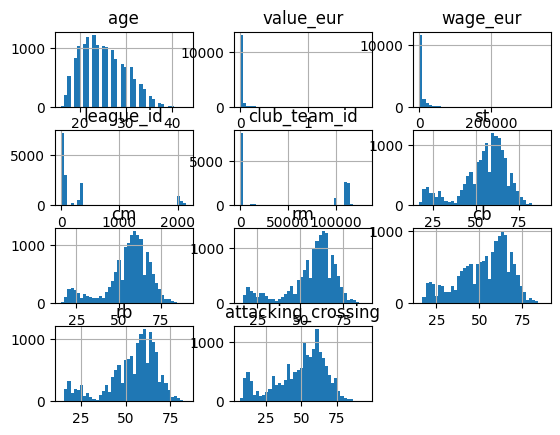

In [894]:
X_train.loc[ : , ["age","value_eur","wage_eur","league_id","club_team_id","st","cm","rm","cb","rb","attacking_crossing"]].hist(bins=40)
# Note : ST,CM,RM,CB,RB follows approximately bell curve

### normalize and standarize 

In [895]:
import math
normalized_cols = []
standarized_cols = ["st","cm","rm","cb","rb","value_eur","wage_eur"] # generally for attributes that have bell curve or follow a normal distribution
scaled_cols =  normalized_cols +(standarized_cols) 
for col in scaled_cols :

    min = X_train[col].min()
    max = X_train[col].max()
    mean = X_train[col].mean()
    std =  X_train[col].std()
    
    
    if col in normalized_cols : 
        X_train[col] = (X_train[col] - min)/(max - min)
        X_test[col] = (X_test[col] - min)/(max - min)

    elif col in standarized_cols : 
        X_train[col] = (X_train[col] - mean)/(std)
        X_test[col] =(X_test[col]- mean)/(std)
# Create a MinMaxScaler
scaler = MinMaxScaler()

# # Fit the scaler on the training data and transform both training and test data
# X_train_scaled = X_train.copy()  
# X_test_scaled = X_test.copy()    

# X_train_scaled[scaled_cols] = scaler.fit_transform(X_train_scaled[scaled_cols])
# X_test_scaled[scaled_cols] = scaler.transform(X_test_scaled[scaled_cols])
        




In [896]:
X_train_scaled 

,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,club_position,club_jersey_number,...,goalkeeping_reflexes,goalkeeping_speed,st,cm,rm,cb,rb,gk,work_rate_attacking,work_rate_defending
16953,0.001081,0.000000,25,165,69,113257.0,2149.0,1.0,2,32.0,...,15,15.0,0.465753,0.540541,0.561644,0.520548,0.585714,15,1,1
7936,0.001838,0.004292,34,178,76,115494.0,17.0,2.0,6,5.0,...,9,15.0,0.520548,0.648649,0.602740,0.643836,0.657143,17,1,1
16999,0.000703,0.004292,29,174,69,114628.0,2012.0,1.0,11,16.0,...,14,15.0,0.520548,0.418919,0.547945,0.438356,0.557143,15,1,1
558,0.089140,0.044349,28,184,80,237.0,308.0,1.0,7,2.0,...,14,15.0,0.671233,0.716216,0.753425,0.876712,0.900000,17,1,2
16295,0.001973,0.000000,17,182,78,114554.0,54.0,2.0,7,28.0,...,6,15.0,0.342466,0.364865,0.383562,0.575342,0.571429,12,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.004135,0.012876,25,180,68,1940.0,61.0,4.0,1,40.0,...,10,15.0,0.643836,0.581081,0.684932,0.383562,0.514286,15,2,1
11964,0.005352,0.015737,21,174,65,240.0,53.0,1.0,12,36.0,...,9,15.0,0.465753,0.527027,0.589041,0.602740,0.671429,15,2,1
5390,0.014001,0.058655,22,185,72,1961.0,14.0,2.0,7,24.0,...,8,15.0,0.534247,0.621622,0.630137,0.739726,0.757143,15,1,1
860,0.126980,0.204578,21,182,73,5.0,13.0,1.0,8,11.0,...,15,15.0,0.739726,0.702703,0.821918,0.438356,0.585714,18,1,0


In [897]:
X_test

,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_id,league_level,club_position,...,rdm,rwb,lb,lcb,cb,rcb,rb,gk,work_rate_attacking,work_rate_defending
9353,66,-0.268761,-0.359547,29,182,74,111083.0,66.0,1.0,1,...,47,50,49,47,-0.390865,47,-0.336448,16,1,0
14446,61,-0.360678,-0.198811,31,180,79,607.0,350.0,1.0,4,...,28,27,27,25,-1.865163,25,-1.889122,60,1,1
12708,63,-0.316071,-0.198811,28,188,74,1940.0,61.0,4.0,1,...,48,52,50,47,-0.390865,47,-0.265872,13,2,1
12878,81,-0.251864,-0.426521,19,178,70,210.0,17.0,2.0,6,...,61,61,62,62,0.614338,62,0.581041,14,1,1
11198,69,-0.268761,-0.439916,22,177,71,111332.0,2019.0,1.0,12,...,60,62,62,60,0.480311,60,0.581041,18,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14650,74,-0.305933,-0.198811,20,178,73,1804.0,61.0,4.0,15,...,56,58,58,59,0.413297,59,0.298737,13,1,1
14874,69,-0.309312,-0.413126,22,176,70,112558.0,83.0,1.0,11,...,41,47,45,36,-1.128014,36,-0.618752,17,1,1
1370,76,-0.113312,0.712027,35,188,82,1035.0,7.0,1.0,7,...,72,69,71,76,1.552528,76,1.216226,17,1,1
3090,75,0.008343,0.336976,25,183,65,379.0,16.0,1.0,12,...,69,70,70,69,1.083433,69,1.145650,15,1,1


## Reducing Number of Attributes Based on Overall Correlation

To streamline our analysis, we will reduce the number of attributes by eliminating those whose correlation with the overall rating falls below a specified threshold. This selective approach helps maintain focus on the most influential features in predicting player overall ratings.


In [898]:
threshold = 0.2 # very low threshold 
corr_matrix = players_2024_clean.corr()
corr_with_target = corr_matrix["overall"]
cols_not_correlated = corr_with_target[ abs(corr_with_target)<=threshold ].index
cols_not_correlated

Index(['height_cm', 'weight_kg', 'league_level', 'club_position',
       'club_jersey_number', 'club_joined_date',
       'club_contract_valid_until_year', 'nationality_id', 'preferred_foot',
       'body_type', 'movement_acceleration', 'movement_balance',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed',
       'gk', 'work_rate_attacking', 'work_rate_defending'],
      dtype='object')

### dropping the columns not correllated to overall

In [899]:
## drop columns not correlated with X_train
X_train = X_train.drop(columns = ['height_cm', 'club_position', 'preferred_foot', 'body_type',"body_type","weight_kg","league_level","club_jersey_number","club_joined_date"
           ,"club_contract_valid_until_year","movement_balance","gk"] )

In [900]:
X_train
X_train.shape

(14680, 46)

In [901]:
def variance_threshold_selector(X_train, threshold=0.0):
    selector = VarianceThreshold(threshold)
    selector.fit(X_train)
    return X_train.columns[selector.get_support(indices=True)]

In [902]:
print(X_train["league_id"].var())

376457.790150053


In [903]:
def variance_threshold_selector(X_train, threshold=0.0):
    selector = VarianceThreshold(threshold)
    selector.fit(X_train)
    return X_train.columns[selector.get_support(indices=True)]

In [904]:
def correlation_selector(X_train, threshold=0.8):
    corr_matrix = X_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return to_drop

In [905]:
def chi_squared_selector(X_train, y, top_k=4):
    selector = SelectKBest(y, k=top_k)
    selector.fit(X_train,selector)
    return X_train[X_train.columns[selector.get_support(indices=True)]]

In [906]:
# Feature selection using mutual information
def mutual_info_selector(mutual_info_classif,X_train , top_k=4):
    selector = SelectKBest(mutual_info_classif, k=top_k)
    selector.fit(X_train,mutual_info_classif)
    return X_train[X_train.columns[selector.get_support(indices=True)]]

In [907]:
def information_gain_selector(X_train, y, top_k=4):
    selector = SelectKBest(score_func=mutual_info_classif, k=top_k)
    X_train_selected = selector.fit_transform(X_train, y)
    return X_train.columns[selector.get_support(indices=True)]

In [908]:
correlation_selector(X_train.iloc[ : , 1 : ],0.7)

['shooting',
 'passing',
 'dribbling',
 'attacking_crossing',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'movement_agility',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'mentality_aggression',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'goalkeeping_diving',
 'goalkeeping_handling',
 'goalkeeping_kicking',
 'goalkeeping_positioning',
 'goalkeeping_reflexes',
 'goalkeeping_speed',
 'st',
 'cm',
 'rm',
 'cb',
 'rb']

In [909]:
dropped = [ col for col in X_test.columns if col not in X_train.columns]
print(dropped)
X_test.drop(columns=dropped,inplace=True)
print(X_test)


['potential', 'height_cm', 'weight_kg', 'league_level', 'club_position', 'club_jersey_number', 'club_joined_date', 'club_contract_valid_until_year', 'preferred_foot', 'body_type', 'release_clause_eur', 'attacking_finishing', 'skill_dribbling', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_balance', 'power_long_shots', 'mentality_interceptions', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'ls', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'rcm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'rcb', 'gk']
       value_eur  wage_eur  age  club_team_id  league_id  nationality_id  \
9353   -0.268761 -0.359547   29      111083.0       66.0              45   
14446  -0.360678 -0.198811   31         607.0      350.0             183   
12708  -0.316071 -0.198811   28        1940.0       61.0              14   
12878  -0.251864 -0.426521   19         210.0       17.0              18   
11198

In [910]:
X_train.head()

,value_eur,wage_eur,age,club_team_id,league_id,nationality_id,weak_foot,skill_moves,international_reputation,pace,...,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,st,cm,rm,cb,rb,work_rate_attacking,work_rate_defending
16953,-0.355271,-0.439916,25,113257.0,2149.0,159,3,2,1,63.0,...,9,15,15.0,-0.285172,0.031135,-0.048864,0.011216,0.087009,1,1
7936,-0.336347,-0.359547,34,115494.0,17.0,97,3,3,1,49.0,...,15,9,15.0,0.008827,0.632919,0.163887,0.614338,0.439889,1,1
16999,-0.364733,-0.359547,29,114628.0,2012.0,155,2,2,1,83.0,...,10,14,15.0,0.008827,-0.645873,-0.119781,-0.390865,-0.054144,1,1
558,1.846691,0.390554,28,237.0,308.0,54,2,3,1,73.0,...,7,14,15.0,0.817324,1.009035,0.943973,1.753568,1.639683,1,2
16295,-0.332968,-0.439916,17,114554.0,54.0,45,3,2,1,56.0,...,9,6,15.0,-0.946669,-0.946766,-0.970785,0.279270,0.016433,1,1


In [911]:
X_test

,value_eur,wage_eur,age,club_team_id,league_id,nationality_id,weak_foot,skill_moves,international_reputation,pace,...,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,st,cm,rm,cb,rb,work_rate_attacking,work_rate_defending
9353,-0.268761,-0.359547,29,111083.0,66.0,45,3,3,1,67.0,...,11,8,15.0,0.817324,-0.044089,0.305721,-0.390865,-0.336448,1,0
14446,-0.360678,-0.198811,31,607.0,350.0,183,3,1,1,51.0,...,59,63,51.0,-2.049165,-1.924666,-1.963622,-1.865163,-1.889122,1,1
12708,-0.316071,-0.198811,28,1940.0,61.0,14,5,3,1,85.0,...,6,6,15.0,0.596825,-0.044089,0.376638,-0.390865,-0.265872,2,1
12878,-0.251864,-0.426521,19,210.0,17.0,18,3,2,1,66.0,...,10,9,15.0,0.302826,0.256804,0.234804,0.614338,0.581041,1,1
11198,-0.268761,-0.439916,22,111332.0,2019.0,61,3,2,1,69.0,...,12,11,15.0,0.229326,0.256804,0.305721,0.480311,0.581041,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14650,-0.305933,-0.198811,20,1804.0,61.0,14,3,3,1,67.0,...,6,12,15.0,-0.358672,-0.269758,-0.119781,0.413297,0.298737,1,1
14874,-0.309312,-0.413126,22,112558.0,83.0,167,3,3,1,70.0,...,15,10,15.0,0.008827,-0.344981,0.163887,-1.128014,-0.618752,1,1
1370,-0.113312,0.712027,35,1035.0,7.0,54,3,2,1,68.0,...,9,7,15.0,-0.211672,0.407250,0.092970,1.552528,1.216226,1,1
3090,0.008343,0.336976,25,379.0,16.0,7,3,2,1,68.0,...,8,13,15.0,0.523325,0.708143,0.589389,1.083433,1.145650,1,1


In [912]:
y_train

16953    56
7936     67
16999    56
558      79
16295    57
         ..
11284    64
11964    63
5390     69
860      77
15795    58
Name: overall, Length: 14680, dtype: int64

In [913]:
y_test

9353     66
14446    61
12708    63
12878    62
11198    64
         ..
14650    60
14874    60
1370     76
3090     72
12382    63
Name: overall, Length: 3670, dtype: int64

### build a model 
let's start with a RandomForestRegressor model


In [914]:

# Create a RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Mean absolute Error: {mae}")

Mean Squared Error: 0.4374379291553134
R^2 Score: 0.990300013460076
Mean absolute Error: 0.40748773841961866


In [916]:
scores_dict = {'Random Forest' : [r2.round(4), mse.round(2), mae.round(2)]}


we run the linear regression model 

In [917]:

# Create a Linear Regression model
linear_model = LinearRegression()

# Fit the model to the training data
linear_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_linear = linear_model.predict(X_test)

# Evaluate the Linear Regression model
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred)


print("Linear Regression Model:")
print(f"Mean Squared Error: {mse_linear}")
print(f"R^2 Score: {r2_linear}")
print(f"Mean Absolute Error: {mae_linear}")


Linear Regression Model:
Mean Squared Error: 4.500384277924013
R^2 Score: 0.9002060315056745
Mean Absolute Error: 0.40748773841961866


In [918]:
scores_dict['Linear Regression'] = [r2_linear.round(4), mse_linear.round(2), mse_linear.round(2)]


the X_trainGBRegressor model 

In [919]:
# Create X_trainGBoost Regressor instance
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

# Train the model
xgb_model.fit(X_train, y_train)

#make predictions 
y_pred = xgb_model.predict(X_test)

# evaluate the model 
mse_boost = mean_squared_error(y_test, y_pred)
r2_boost = r2_score(y_test, y_pred_linear)
mae_boost = mean_absolute_error(y_test, y_pred)


print(f'Mean Squared Error: {mse_boost}')
print(f"R^2 Score: {r2_boost}")
print(f"Mean absolute error: {mae_boost}")



Mean Squared Error: 0.7623523873052108
R^2 Score: 0.9002060315056745
Mean absolute error: 0.5978456585543682


In [920]:
scores_dict['X_trainGBoost'] = [r2_boost.round(4), mse_boost.round(2), mae_boost.round(2)]


### comparison 
We can compare our performance metrics below:



In [921]:
# Create a dataframe from the dictionary
scores_df = pd.DataFrame(scores_dict, index = ['r2', 'mse', 'mae'])
scores_df
     

,Random Forest,Linear Regression,X_trainGBoost
r2,0.9988,0.9002,0.9002
mse,0.0600,4.5000,0.7600
mae,0.1500,4.5000,0.6000
